# 1. Load Libraries

Load the most important libraries

In [1]:
#load libraries used during the project; some libraries might be loaded at a later stage
import numpy as np
import keras
import pandas as pd
import nltk
import locale
import unicodedata
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt


/home/fe/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 2. Load Data

The data loading and preprocessing starts here.

In [2]:
#read the raw data from file; the file is zipped
raw_data = pd.read_csv('trainData.csv.gz', sep='\t', encoding ='utf8', compression='gzip')
raw_data.set_index('url', inplace=True)


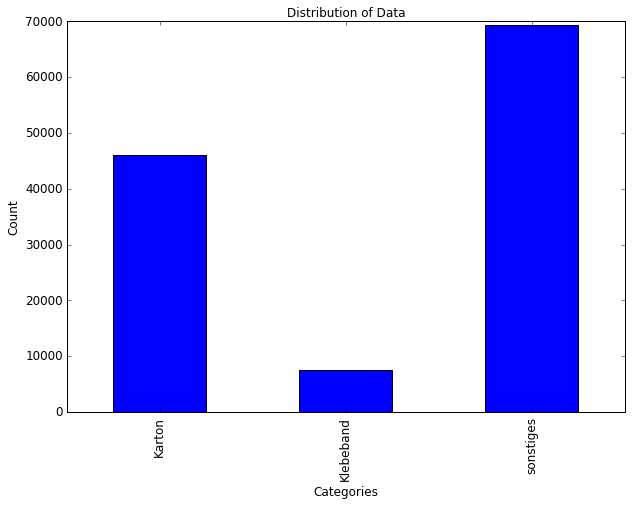

In [3]:
#show the distribution of the target classes
raw_data.head()

counts = raw_data.groupby(['category_manually']).agg(['count'])

cat = counts[['category']].plot(kind='bar', title="Distribution of Data", figsize=(10, 7), legend=False ,fontsize=12)
cat.set_xlabel("Categories", fontsize=12)
cat.set_ylabel("Count", fontsize=12)
#cat.legend(bbox_t_anchor=(1,0.2))
plt.show()



# 3 Clean Data

In this section the data is running through a cleaning process. Certain characters are deleted and stopwords are removed. Also a stemming function has been implemented. Since this did not show any considerable impact on the results it is however not used anymore.

## Define Function to Clean Data

In [4]:
#this function can be used for stemming; it uses nltk.SnowballStemmer to reduce a word to its stem
def stem_description(text):
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    stemmer = SnowballStemmer("german")  #the stemmer is used to get the stem for each word; this should reduce the size of the vocabulary and make it easier for the algorithms later on to detect patterns
    for i, word in enumerate(tokens):
        tokens[i] = stemmer.stem(word)
    return ' '.join(tokens)   

In [5]:
import re
def clean_word(description, remove_stopwords=True):
    #if stemmer is not used the 2 lines below will take care of umlaute and the german s
    description = description.replace(u"\u00DF","ss") #replace sharp s; since this is not considered by the function below
    description = unicodedata.normalize('NFKD', description).encode('ascii', 'ignore') #Normalise (normalize) unicode data in Python to remove umlauts, accents etc.
    # remove everything which is not a character or a digit
    description = re.sub("-1","",description) #-1 is used as a error code in the extraction process
    description = re.sub("[^a-zA-Z0-9\- ]"," ",description) #this will delete punctuation
    # convert to lower case
    description = description.lower()
    #description = re.sub("(^|\b)\d+\s","1", description)
    description = re.sub("\d+\s*x","1x", description) #the 2 lines will replace measurements with one unique string
    description = re.sub("x\s*\d+","x1", description)
    description = re.sub("\d+","1 ", description) #replace numbers by 1 to avoid an unnecessary big vocabulary
    
    #remove stopwords
    words = description.split()
    #print words.__class__
    stops = set(nltk.corpus.stopwords.words("german"))
    if remove_stopwords:
        processed_words = []
        description = [w for w in words if not w in stops]
    return ' '.join(description)

## Call Clean Data Function

In [6]:
#calling this function will clean the raw data 
locale.setlocale(locale.LC_ALL, 'de_DE.utf8') # set language to german
for i, row in raw_data.iterrows():
    #stem_words = stem_description((row['description'])) #It seems that this has no effect on the results; therefore deactivated
    clean_description = clean_word(row['description']) #change back to stem_words if you want to use the stemmer
    raw_data.set_value(i,'description', clean_description)

# 4 Split into Training, Testing and Validation Data

This section splits the cleaned data int a training, testing and validation junks. Also the target classes (Y data) are text labels. They are converted into numbers by a label encoder.

In [7]:
# convert labels to in
from pathlib2 import Path
import os
import pickle

filename="label_encoder.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()
#if model file exist then load it
if model_file_exist==True:
    print('Load Label Encoder')
    le = pickle.load(open(filename, 'rb'))
    Y = le.transform(raw_data['category_manually'])
else:
#if model file does not exist then fit the data and save the model to file    
    print('Fit Label Encoder')
    le = preprocessing.LabelEncoder()
    Y = le.fit_transform(raw_data['category_manually'])
    pickle.dump(le, open(filename, 'wb'))
    
Y_pd = pd.DataFrame(Y, index=raw_data.index)  #convert into pandas df and add index
Y_pd.rename(columns={0: 'original_category'}, inplace=True) #
    
   

Load Label Encoder


In [8]:
#split the data into train, test and validation dat
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(raw_data['description'], Y_pd, test_size=0.1, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)


In [9]:
print le.inverse_transform([0,1,2])

[u'Karton' u'Klebeband' u'sonstiges']


/home/fe/tensorflow/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 5 Create Bag Of Words

The following code will convert the text data into a matrix. Each column represents one word. The number of columns is limited to 5.000 words. The TfidfVectorizer is used since the frequency seems to be more important than a simple count since the text descriptions vary considerably in length.

In [10]:
filename="tfidf_vectorizer.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()
#if model file exists already then load it without fitting
if model_file_exist==True:
    print('Load Tfidf Vectorizer')
    vectorizer=pickle.load(open(filename, 'rb'))
    X_train_description_matrix = vectorizer.transform(X_train) # This will create the matrix based on the 20.000 most used words and transform the train data into this matrix
else:
    print('Fit Tfidf Vectorizer')
    vectorizer = TfidfVectorizer(analyzer = "word",max_features = 5000, sublinear_tf=True, use_idf=True, norm="l1")
    X_train_description_matrix = vectorizer.fit_transform(X_train) # This will create the matrix based on the 20.000 most used words and transform the train data into this matrix
    # save the model to disk
    pickle.dump(vectorizer, open(filename, 'wb'))
X_test_description_matrix = vectorizer.transform(X_test) # This will transform the test data into the matrix
X_val_description_matrix = vectorizer.transform(X_val)



Load Tfidf Vectorizer


# 6 Create Word2Vec

This will train a word2vec based on the given data. The word2vec is used to reduce the dimensionality from 5.000 features (as defined in the bag of words) down to 100 features. This should improve the performance as well as the accuracy of the model.

In [11]:
import gensim

filename="embeddings.bin.gz"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

#if model file exists then load it without fitting it
if model_file_exist==True:
    print('Load Word2Vec')
    word2vec = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True)
else:
    print('Fit Word2Vec')
    word2vec_feed = []
    word2vec_feed = X_train.tolist() #convert into list for the word2vec algorithm
    word2vec = gensim.models.Word2Vec([s.encode('utf-8').split( ) for s in word2vec_feed], size=100, window=5, min_count=5, workers=4)

    word2vec.wv.save_word2vec_format('embeddings.bin.gz', binary=True)



Load Word2Vec


In [12]:
   
print('Found %s word vectors of word2vec' % len(word2vec.wv.vocab))
print("Most similar words to Faltkarton:", ", ".join(map(lambda x: x[0], word2vec.wv.most_similar("faltkarton"))))


Found 27173 word vectors of word2vec
('Most similar words to Faltkarton:', u'maxibrief-karton, faltkartons, maxibriefkarton, grossbrief-karton, grossbriefkarton, -wellig, klappdeckel-karton, maxibrief, dvd-karton, faltschachtel')


## Remove less frequent words in raw data
This is done to delete the words from the description which are not part of the vocabulary defined in the TfidfVectorizer. A maximum of 5000 words is defined there. 

In [13]:
def remove_less_frequent_words(description, top_words):
    words = description.split()
    words_copy = words
    #top_frequent_words = set(top_words['word'])
    for word in list(words_copy):  # iterating on a copy since removing will mess things up
        if word not in top_words:
            words.remove(word)               
    return ' '.join(words)

In [14]:
def remove_words_from_dataset(dataframe, top_words):
    for i, row in dataframe.iterrows():
        #stem_words = stem_description((row['description'])) #It seems that this has no effect on the results; therefore deactivated
        clean_description = remove_less_frequent_words(row['description'], top_words) #change back to stem_words if you want to use the stemmer
        dataframe.set_value(i,'description', clean_description) 
    return dataframe

In [15]:

top_words = set(vectorizer.get_feature_names()) #get most frequent words from bow
# display(top_words)
X_train_words = pd.DataFrame(X_train, index=Y_train.index)
X_test_words = pd.DataFrame(X_test, index=Y_test.index)
X_val_words = pd.DataFrame(X_val, index=Y_val.index)
X_train_words = remove_words_from_dataset(X_train_words, top_words)
X_test_words =remove_words_from_dataset(X_test_words, top_words)
X_val_words = remove_words_from_dataset(X_val_words, top_words)
        

# 7 Singular Value Decomposition

Another approach to reduce the dimensionality of the input data is to use singular value decomposition

In [16]:
from sklearn.decomposition import TruncatedSVD

filename="truncated_svd.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load Truncated SVD')
    svd=pickle.load(open(filename, 'rb'))
    X_train_svd = svd.fit_transform(X_train_description_matrix)
else: 
    print('Fit Truncated SVD')
    svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
    X_train_svd = svd.fit_transform(X_train_description_matrix)
    # save the model to disk
    pickle.dump(svd, open(filename, 'wb'))

X_test_svd = svd.transform(X_test_description_matrix)
X_val_svd = svd.transform(X_val_description_matrix)

Load Truncated SVD


In [17]:
#Convert data into pandas dataframe
X_train_red =pd.DataFrame(X_train_svd, index=Y_train.index)
X_test_red = pd.DataFrame(X_test_svd, index=Y_test.index)
X_val_red = pd.DataFrame(X_val_svd, index=Y_val.index)
print("Done converting X_red data to pandas data frame")

Done converting X_red data to pandas data frame


# 9 Train various models and calculate the accuracy on training and test data


## 9.1 Logistic Regression

Train a logistic regression model.

In [18]:
def check_overfitting(X_ov, Y_ov, model):
#for each iteration take 80% of the data, fit the model and print the test and train score. This should give us some insights on overfitting
#This is done since the cross_val_score only provides the average score for the training sets
    for i in range(5):
        X_train_ov, X_test_ov, Y_train_ov, Y_test_ov = train_test_split(X_ov, Y_ov, test_size=0.2, stratify=Y_ov)
        model.fit(X_test_ov, Y_test_ov)
        print "Test score", model.score(X_test_ov, Y_test_ov)   
        print "Train score", model.score(X_train_ov, Y_train_ov) 

In [19]:
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
filename="logreg_model.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load Logreg model')
    logreg = pickle.load(open(filename, 'rb'))
else:
    print('Fit Logreg model')
    logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced", n_jobs=3, random_state=42, max_iter=1000)
    check_overfitting(X_train_red, Y_train['original_category'], logreg)

    # At the end fit the model to the whole training data set
    logreg.fit(X_train_red, Y_train['original_category'])
    # save the model to disk
    pickle.dump(logreg, open(filename, 'wb'))
    print('Trained Logreg model')
print "Final Test Score: ", logreg.score(X_test_red, Y_test['original_category'])
print "Final Train Score: ",logreg.score(X_train_red, Y_train['original_category'])

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], logreg.predict(X_test_red))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], logreg.predict(X_train_red))



Load Logreg model
Final Test Score:  0.9612996563988185
Final Train Score:  0.9649886167790804

Confusion Matrix Test:
[[6060    1  229]
 [   0  927   48]
 [ 289   75 8960]]
Confusion Matrix Train:
[[33701    18  1321]
 [    3  5529   219]
 [ 1334   396 51477]]


In [20]:
#verify whether over-sampling will make any differnce
#note that the randomOverSampler will convert pandas dataframe into a numpy array
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train_red_resampled, Y_train_resampled = ros.fit_sample(X_train_red, Y_train)

filename="logreg_resampled_model.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load Logreg resampled model')
    logreg_resampled = pickle.load(open(filename, 'rb'))
else:
    print('Fit Logreg resampled model')
    logreg_resampled = linear_model.LogisticRegression(C=1e5, class_weight="balanced", n_jobs=3, random_state=42, max_iter=1000)
    check_overfitting(X_train_red_resampled, Y_train_resampled, logreg_resampled)
    pickle.dump(logreg_resampled, open(filename, 'wb'))
    # At the end fit the model to the whole training data set
print "Final Test Score: ", logreg_resampled.score(X_test_red, Y_test['original_category'])
print "Final Train Score: ",logreg_resampled.score(X_train_red, Y_train['original_category'])

#the oversampling did not have much impact; it slightly reduced the accuracy

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], logreg_resampled.predict(X_test_red))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], logreg_resampled.predict(X_train_red))

/home/fe/tensorflow/local/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Load Logreg resampled model
Final Test Score:  0.9568991500391826
Final Train Score:  0.9619885529479351

Confusion Matrix Test:
[[6088    2  200]
 [   0  944   31]
 [ 350  132 8842]]
Confusion Matrix Train:
[[33854    25  1161]
 [    3  5625   123]
 [ 1573   688 50946]]


## 9.2 Naive Bayes

Train a Naive Bayes model

In [21]:
from sklearn.naive_bayes import GaussianNB

filename="naive_bayes.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load Gaus model')
    gaus = pickle.load(open(filename, 'rb'))
else:
    print('Fit Gaus model')
    gaus = GaussianNB()
    check_overfitting(X_train_red, Y_train['original_category'], gaus)
    gaus.fit(X_train_red, Y_train['original_category'])
    pickle.dump(gaus, open(filename, 'wb'))
print "Final Test Score: ", gaus.score(X_test_red, Y_test['original_category'])
print "Final Train Score: ",gaus.score(X_train_red, Y_train['original_category'])

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], gaus.predict(X_test_red))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], gaus.predict(X_train_red))


filename="naive_bayes_resampled.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load Gaus resampled model')
    gaus_resampled = pickle.load(open(filename, 'rb'))
else:
    print('Fit Gaus resampled model')
    gaus_resampled = GaussianNB()
    check_overfitting(X_train_red_resampled, Y_train_resampled, gaus_resampled)

    gaus_resampled.fit(X_train_red_resampled, Y_train_resampled)
    pickle.dump(gaus_resampled, open(filename, 'wb'))
print "Final Test Score: ", gaus_resampled.score(X_test_red, Y_test['original_category'])
print "Final Train Score: ",gaus_resampled.score(X_train_red, Y_train['original_category'])


print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], gaus_resampled.predict(X_test_red))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], gaus_resampled.predict(X_train_red))

Load Gaus model
Final Test Score:  0.4697691241183917
Final Train Score:  0.47231855996936106

Confusion Matrix Test:
[[3666 2055  569]
 [   9  873   93]
 [2141 3929 3254]]
Confusion Matrix Train:
[[20400 11291  3349]
 [   43  5160   548]
 [12220 22150 18837]]
Load Gaus resampled model
Final Test Score:  0.45475917776840075
Final Train Score:  0.4577225047341433

Confusion Matrix Test:
[[3487 2255  548]
 [  10  874   91]
 [1986 4155 3183]]
Confusion Matrix Train:
[[19427 12315  3298]
 [   41  5173   537]
 [11436 23346 18425]]


## 9.3 Random Forest

Train a random forest model

In [22]:
from sklearn.ensemble import RandomForestClassifier

filename="random_forest.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load Random forest model')
    random_forest = pickle.load(open(filename, 'rb'))
else:
    print('Fit Random forest model')
    random_forest = RandomForestClassifier(max_depth=25, min_samples_split=15, n_jobs=3, class_weight="balanced", random_state=42, )
    check_overfitting(X_train_red, Y_train['original_category'], random_forest)
    # At the end fit the model to the whole training data set
    random_forest.fit(X_train_red, Y_train['original_category'])
    pickle.dump(random_forest, open(filename, 'wb'))
print "Final Test Score: ", random_forest.score(X_test_red, Y_test['original_category'])
print "Final Train Score: ",random_forest.score(X_train_red, Y_train['original_category'])

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], random_forest.predict(X_test_red))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], random_forest.predict(X_train_red))



filename="random_forest_resampled.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load Random forest resampled model')
    random_forest_resampled = pickle.load(open(filename, 'rb'))
else:
    print('Fit Random forest resampled model')
    random_forest_resampled = RandomForestClassifier(max_depth=25, min_samples_split=15, n_jobs=3, class_weight="balanced", random_state=42, )
    check_overfitting(X_train_red_resampled, Y_train_resampled, random_forest)
    # At the end fit the model to the whole training data set
    random_forest_resampled.fit(X_train_red_resampled, Y_train_resampled)
    pickle.dump(random_forest_resampled, open(filename, 'wb'))
print "Final Test Score: ", random_forest_resampled.score(X_test_red, Y_test['original_category'])
print "Final Train Score: ",random_forest_resampled.score(X_train_red, Y_train['original_category'])

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], random_forest_resampled.predict(X_test_red))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], random_forest_resampled.predict(X_train_red))


Load Random forest model
Final Test Score:  0.9714268491168847
Final Train Score:  0.9805102236217792

Confusion Matrix Test:
[[6105    2  183]
 [   0  934   41]
 [ 182   66 9076]]
Confusion Matrix Train:
[[34259     4   777]
 [    0  5705    46]
 [  687   318 52202]]
Load Random forest resampled model
Final Test Score:  0.9883657845560311
Final Train Score:  0.9976488861465137

Confusion Matrix Test:
[[6212    0   78]
 [   0  942   33]
 [  63   19 9242]]
Confusion Matrix Train:
[[34962     0    78]
 [    0  5751     0]
 [   73    70 53064]]


In [23]:
#This function can be used to save mismatches to a file for detailed analysis
def save_mismatches_to_file(X,Y, model, filename):
    results = model.predict(X)
    results_table = pd.DataFrame(results, index=Y.index)  #convert into pandas df and add index
    results_table.rename(columns={0: 'prediction'}, inplace=True)

    results_table = pd.concat([results_table,Y['original_category']], axis=1, join_axes=[results_table.index])
   # results_table = pd.concat([results_table,raw_data['description']], axis=1, join_axes=[results_table.index])
    results_table['prediction']=le.inverse_transform(results_table['prediction'])
    results_table['original_category']=le.inverse_transform(results_table['original_category'])


    results_table_unmatched = results_table.loc[~(results_table['prediction'] == results_table['original_category'])]

    results_table_unmatched = results_table_unmatched.join(raw_data['description'])
    results_table_unmatched.to_csv(filename, sep='\t', encoding='utf-8')

In [24]:
#from sklearn.metrics import confusion_matrix

#save_mismatches_to_file(X_test_svd, Y_test, random_forest, 'test_results_table.txt')
#save_mismatches_to_file(X_train_svd, Y_train, random_forest, 'train_results_table.txt')
#confusion_matrix(Y_test['original_category'], random_forest.predict(X_test_svd))


   ## 9.4 Gradient Boost Classifier
   
   Train gradient boost classifier

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

filename="gradient_booster.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load Gradient boost model')
    gradient_booster = pickle.load(open(filename, 'rb'))
else:
    print('Fit Gradient boost model')
    gradient_booster = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=10, min_samples_split=15, random_state=42)
    #check_overfitting(X_train_red, Y_train['original_category'], gradient_booster)
    # At the end fit the model to the whole training data set
    gradient_booster.fit(X_train_red, Y_train['original_category'])
    pickle.dump(gradient_booster, open(filename, 'wb'))
print "Final Test Score: ", gradient_booster.score(X_test_red, Y_test['original_category'])
print "Final Train Score: ",gradient_booster.score(X_train_red, Y_train['original_category'])

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], gradient_booster.predict(X_test_red))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], gradient_booster.predict(X_train_red))


filename="gradient_booster_resampled.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load Gradient boost resampled model')
    gradient_booster_resampled = pickle.load(open(filename, 'rb'))
else:
    print('Fit Gradient boost resampled model')
    gradient_booster_resampled = RandomForestClassifier(max_depth=25, min_samples_split=15, n_jobs=3, class_weight="balanced", random_state=42, )
    #check_overfitting(X_train_red_resampled, Y_train_resampled, gradient_booster_resampled)
    # At the end fit the model to the whole training data set
    gradient_booster_resampled.fit(X_train_red_resampled, Y_train_resampled)
    pickle.dump(gradient_booster_resampled, open(filename, 'wb'))
print "Final Test Score: ", gradient_booster_resampled.score(X_test_red, Y_test['original_category'])
print "Final Train Score: ",gradient_booster_resampled.score(X_train_red, Y_train['original_category'])

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], gradient_booster_resampled.predict(X_test_red))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], gradient_booster_resampled.predict(X_train_red))

Load Gradient boost model
Final Test Score:  0.9899330881909699
Final Train Score:  0.9992553033043257

Confusion Matrix Test:
[[6226    0   64]
 [   0  934   41]
 [  52   10 9262]]
Confusion Matrix Train:
[[35012     0    28]
 [    0  5749     2]
 [   35     5 53167]]
Load Gradient boost resampled model
Final Test Score:  0.9883657845560311
Final Train Score:  0.9976488861465137

Confusion Matrix Test:
[[6212    0   78]
 [   0  942   33]
 [  63   19 9242]]
Confusion Matrix Train:
[[34962     0    78]
 [    0  5751     0]
 [   73    70 53064]]


In [26]:

print "Final Val Score: ", gradient_booster.score(X_val_red, Y_val['original_category'])



save_mismatches_to_file(X_test_red, Y_test, gradient_booster, 'gradient_booster_test_results_table.txt')
save_mismatches_to_file(X_train_red, Y_train, gradient_booster, 'gradient_booster_train_results_table.txt')
save_mismatches_to_file(X_val_red, Y_val, gradient_booster, 'gradient_booster_val_results_table.txt')
confusion_matrix(Y_test['original_category'], gradient_booster.predict(X_test_red))

Final Val Score:  0.9908854166666666


/home/fe/tensorflow/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/fe/tensorflow/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/fe/tensorflow/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/fe/tensorflow/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

array([[6226,    0,   64],
       [   0,  934,   41],
       [  52,   10, 9262]])

# 9.5 Prepare Data for Neural Networks

In [27]:
# prepare data and embedding layer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from sklearn.preprocessing import LabelBinarizer

MAX_NB_WORDS = 5000 #this is the max number of words considered by the tokenizer; one-hot-encoder
MAX_SEQUENCE_LENGTH = 30 #this is the maximum number of words presented to the models for each product.
EMBEDDING_DIM = 100 #this is the number of output vectors for the word2vec model

filename="tokenizer.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

#the tokenizer will do the one-hot encoding, load the model if exists otherwise fit it based on the input data
if model_file_exist==True:
    print('Load tokenizer model')
    tokenizer=pickle.load(open(filename, 'rb'))
else:    
    print("Fit tokenizer")
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(X_train_words['description'])
    with open(filename, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Convert text to sequences and do padding")

#do the one-hot encoding
description_sequences_training = tokenizer.texts_to_sequences(X_train_words['description'])
#create a padding in case there are less than 30 words per product description
description_data_training = pad_sequences(description_sequences_training, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

description_sequences_test = tokenizer.texts_to_sequences(X_test_words['description'])
description_data_test = pad_sequences(description_sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

description_sequences_val = tokenizer.texts_to_sequences(X_val_words['description'])
description_data_val = pad_sequences(description_sequences_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
print("Done with conversion and padding")

word_index = tokenizer.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))+1

#do some reshaping in order to be able to feed the data into keras
print("reshape Y data for model")
Y_train_3dim = Y_train['original_category'].values
Y_test_3dim = Y_test['original_category'].values
Y_val_3dim = Y_val['original_category'].values

print("start label binarizer for model")
filename="label_binarizer.sav"
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load label_binarizer model')
    label_binarizer=pickle.load(open(filename, 'rb'))
else: 
    print('Fit label_binarizer model')
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(max(Y_train_3dim)+1))
    with open(filename, 'wb') as handle:
        pickle.dump(label_binarizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
Y_train_3dim = label_binarizer.transform(Y_train_3dim)
Y_test_3dim = label_binarizer.transform(Y_test_3dim)
Y_val_3dim = label_binarizer.transform(Y_val_3dim)
print("done with reshaping data")

#create an embedding layer which can be used by various models below
print("prepare embedding layer")
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.wv.vocab and i < nb_words:
        embedding_matrix[i] = word2vec.wv.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_layer = Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
                            embedding_matrix.shape[1], # or EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
print("embedding layer is ready")

Load tokenizer model
Convert text to sequences and do padding
Done with conversion and padding
reshape Y data for model
start label binarizer for model
Load label_binarizer model
done with reshaping data
prepare embedding layer
Null word embeddings: 26
embedding layer is ready


# 9.6 Train Convolutional Neural Network

train 2 different versions of a convolutional neural network.

In [28]:
#create cnn_model 1 

from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Flatten
from keras.layers import Dense, Input, Embedding, Dropout, Activation
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

#define variables
filename='model_cnn_vec.h5'
min_delta_stopping=0.0001
patience_stopping=15
log_dir='./logs'


my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load CNN_1 model')
    model_1=load_model(filename)
    model_1.summary()
else:
    print('Fit CNN_1 model')
    model_1 = Sequential()
    model_1.add(embedding_layer)
    model_1.add(Conv1D(80,3,padding='valid',activation='relu',strides=1))
    model_1.add(GlobalMaxPooling1D())
    model_1.add(Dense(80))
    model_1.add(Dropout(0.2))
    model_1.add(Activation('relu'))
    model_1.add(Dense(3))
    model_1.add(Activation('sigmoid'))
    model_1.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])

    #tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
    checkpoint = ModelCheckpoint(filename, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=min_delta_stopping, patience=patience_stopping, verbose=0, mode='auto')
    model_1.summary()
    # run cnn_model_1
    model_1.fit(description_data_training, Y_train_3dim, validation_data=(description_data_test, Y_test_3dim),callbacks=[checkpoint, early_stopping] , epochs=100, batch_size=128)



Load CNN_1 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           495100    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 80)            24080     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 243 

In [29]:
model_1=load_model(filename)

print("Final Test Score: ", model_1.evaluate(description_data_test, Y_test_3dim, verbose=0))
print ("Final Train Score: ",model_1.evaluate(description_data_training, Y_train_3dim, verbose=0))

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], model_1.predict_classes(description_data_test))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], model_1.predict_classes(description_data_training))


('Final Test Score: ', [0.05198401069773173, 0.9925251672795226])
('Final Train Score: ', [0.009193153458827895, 0.9972871763229005])

Confusion Matrix Test:
16589/16589 [==============================] - 1s 77us/step
[[6247    1   42]
 [   1  956   18]
 [  47   15 9262]]
Confusion Matrix Train:
93998/93998 [==============================] - 7s 74us/step
[[34957     0    83]
 [    1  5725    25]
 [  120    26 53061]]


In [30]:
filename='model_cnn_vec_2.h5'

my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load CNN_2 model')
    model_2=load_model(filename)
    model_2.summary()
else: 
    print('Fit CNN_2 model')
    model_2 = Sequential()
    model_2.add(embedding_layer)
    model_2.add(Dropout(0.2))
    model_2.add(Conv1D(100, 3, padding='valid',activation='relu',strides=2))
    model_2.add(Conv1D(50, 3, padding='valid',activation='relu',strides=2))
    model_2.add(Conv1D(25, 3, padding='valid',activation='relu',strides=2))
    model_2.add(Flatten())
    model_2.add(Dropout(0.2))
    model_2.add(Dense(50,activation='sigmoid'))
    model_2.add(Dropout(0.2))
    model_2.add(Dense(3,activation='sigmoid'))

    checkpoint = ModelCheckpoint(filename, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=min_delta_stopping, patience=patience_stopping, verbose=0, mode='auto')

    model_2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])

    model_2.summary()
    model_2.fit(description_data_training, Y_train_3dim, validation_data=(description_data_test, Y_test_3dim),callbacks=[checkpoint, early_stopping] , epochs=100, batch_size=128)

Load CNN_2 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           495100    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 100)           30100     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 50)             15050     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 25)             3775      
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0   

In [31]:
model_2=load_model(filename)

print("Final Test Score: ", model_2.evaluate(description_data_test, Y_test_3dim, verbose=0))
print ("Final Train Score: ",model_2.evaluate(description_data_training, Y_train_3dim, verbose=0))

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], model_2.predict_classes(description_data_test))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], model_2.predict_classes(description_data_training))

('Final Test Score: ', [0.03847817369668014, 0.9915003918259088])
('Final Train Score: ', [0.01480923536469194, 0.9962552394731803])

Confusion Matrix Test:
16589/16589 [==============================] - 1s 72us/step
[[6248    1   41]
 [   0  959   16]
 [  57   26 9241]]
Confusion Matrix Train:
93998/93998 [==============================] - 6s 69us/step
[[34932     1   107]
 [    0  5734    17]
 [  126   101 52980]]


# 9.7 Train LSTM

In [32]:
from keras.layers import LSTM

filename='model_lstm_vec_1.h5'

my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load LSTM_1 model')
    model_3=load_model(filename)
    model_3.summary()
else: 
    print('Fit LSTM_1 model')
    model_3 = Sequential()
    model_3.add(embedding_layer)
    model_3.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model_3.add(Dense(3, activation='sigmoid'))

    model_3.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    checkpoint = ModelCheckpoint(filename, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=min_delta_stopping, patience=patience_stopping, verbose=0, mode='auto')
    model_3.summary()
    model_3.fit(description_data_training, Y_train_3dim, validation_data=(description_data_test, Y_test_3dim),callbacks=[checkpoint, early_stopping] , epochs=100, batch_size=128)

Load LSTM_1 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           495100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 612,735
Trainable params: 117,635
Non-trainable params: 495,100
_________________________________________________________________


In [33]:
model_3 = load_model(filename)

print("Final Test Score: ", model_3.evaluate(description_data_test, Y_test_3dim, verbose=0))
print ("Final Train Score: ",model_3.evaluate(description_data_training, Y_train_3dim, verbose=0))

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], model_3.predict_classes(description_data_test))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], model_3.predict_classes(description_data_training))

('Final Test Score: ', [0.014518796768941446, 0.9966041764540974])
('Final Train Score: ', [0.0029690487621575044, 0.9988616783341595])

Confusion Matrix Test:
16589/16589 [==============================] - 8s 465us/step
[[6265    0   25]
 [   1  964   10]
 [  34   12 9278]]
Confusion Matrix Train:
93998/93998 [==============================] - 43s 456us/step
[[34983     2    55]
 [    1  5737    13]
 [   76    16 53115]]


In [34]:
from keras.layers import Bidirectional


filename='model_lstm_bi_vec_2.h5'
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load LSTM_2 model')
    model_4=load_model(filename)
    model_4.summary()
else: 
    print('Fit LSTM_2 model')
    model_4 = Sequential()
    model_4.add(embedding_layer)
    model_4.add(Bidirectional(LSTM(50)))
    model_4.add(Dropout(0.3))
    model_4.add(Dense(3, activation='sigmoid'))


    model_4.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    checkpoint = ModelCheckpoint(filename, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=min_delta_stopping, patience=patience_stopping, verbose=0, mode='auto')

    model_4.summary()
    model_4.fit(description_data_training, Y_train_3dim, validation_data=(description_data_test, Y_test_3dim),callbacks=[checkpoint, early_stopping] , epochs=100, batch_size=128)



Load LSTM_2 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           495100    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               60400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total params: 555,803
Trainable params: 60,703
Non-trainable params: 495,100
_________________________________________________________________


In [35]:
model_4 = load_model(filename)

print("Final Test Score: ", model_4.evaluate(description_data_test, Y_test_3dim, verbose=0))
print ("Final Train Score: ",model_4.evaluate(description_data_training, Y_train_3dim, verbose=0))

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], model_4.predict_classes(description_data_test))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], model_4.predict_classes(description_data_training))

('Final Test Score: ', [0.015290891754351412, 0.9966242698988149])
('Final Train Score: ', [0.002273532485174415, 0.9990779950204344])

Confusion Matrix Test:
16589/16589 [==============================] - 6s 376us/step
[[6258    0   32]
 [   0  964   11]
 [  34    7 9283]]
Confusion Matrix Train:
93998/93998 [==============================] - 35s 371us/step
[[34986     0    54]
 [    1  5738    12]
 [   47     8 53152]]


# 9.8 Train Multilayer Perceptron

In [36]:
filename='model_mlp_vec_1.h5'
my_model_file = Path(os.getcwd()+"/"+filename)
model_file_exist = my_model_file.exists()

if model_file_exist==True:
    print('Load MLP_1 model')
    model_5=load_model(filename)
    model_5.summary()
else: 
    print('Fit MLP_1 model')
    model_5 = Sequential()
    model_5.add(embedding_layer)
    model_5.add(Dense(66))
    model_5.add(Dropout(0.2))
    model_5.add(GlobalMaxPooling1D())
    model_5.add(Dense(33))
    model_5.add(Dropout(0.2))
    model_5.add(Dense(3, activation='sigmoid'))

    model_5.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    checkpoint = ModelCheckpoint(model_file_name, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=min_delta_stopping, patience=patience_stopping, verbose=0, mode='auto')
    model_5.summary()
    model_5.fit(description_data_training, Y_train_3dim, validation_data=(description_data_test, Y_test_3dim),callbacks=[checkpoint, early_stopping] , epochs=100, batch_size=128)


Load MLP_1 model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           495100    
_________________________________________________________________
dense_7 (Dense)              (None, 30, 66)            6666      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 66)            0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 66)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 33)                2211      
_________________________________________________________________
dropout_7 (Dropout)          (None, 33)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 102 

In [37]:
model_5 = load_model(filename)

print("Final Test Score: ", model_5.evaluate(description_data_test, Y_test_3dim, verbose=0))
print ("Final Train Score: ",model_5.evaluate(description_data_training, Y_train_3dim, verbose=0))

print("\nConfusion Matrix Test:")
print confusion_matrix(Y_test['original_category'], model_5.predict_classes(description_data_test))
print("Confusion Matrix Train:")
print confusion_matrix(Y_train['original_category'], model_5.predict_classes(description_data_training))

('Final Test Score: ', [0.0235872214947392, 0.9933691033403527])
('Final Train Score: ', [0.012543098806892354, 0.9960637475590028])

Confusion Matrix Test:
16589/16589 [==============================] - 1s 55us/step
[[6240    0   50]
 [   0  951   24]
 [  58   14 9252]]
Confusion Matrix Train:
93998/93998 [==============================] - 4s 43us/step
[[34844     2   194]
 [    7  5697    47]
 [  138    48 53021]]


# 10 Visualize Results

In [39]:
model_name = np.array(['model_mlp_vec_1.h5',
                       'model_lstm_bi_vec_2.h5',
                       'model_lstm_vec_1.h5',
                       'model_cnn_vec_2.h5',
                       'model_cnn_vec.h5'
                      ], dtype=object)
result_table = pd.DataFrame(columns=['train_acc', 
                                     'test_acc', 'val_acc',
                                     'train_confusion', 'test_confusion', 
                                     'val_confusion'], index=model_name)


print result_table.head()
for model_temp_name in model_name:
    print('\n')
    print('Model: ', model_temp_name)
    model_temp = load_model(model_temp_name)
    loss, acc=model_temp.evaluate(description_data_test, Y_test_3dim, verbose=0)
    result_table.set_value(model_temp_name, 'test_acc', acc)
    loss, acc=model_temp.evaluate(description_data_training, Y_train_3dim, verbose=0)
    result_table.set_value(model_temp_name, 'train_acc', acc)
    loss, acc=model_temp.evaluate(description_data_val, Y_val_3dim, verbose=0)
    result_table.set_value(model_temp_name, 'val_acc', acc)
    
    print("\nConfusion Matrix Generation:")
    temp_confusion = confusion_matrix(Y_test['original_category'], model_temp.predict_classes(description_data_test))
    result_table.set_value(model_temp_name, 'test_confusion', temp_confusion)
    temp_confusion = confusion_matrix(Y_train['original_category'], model_temp.predict_classes(description_data_training))
    result_table.set_value(model_temp_name, 'train_confusion', temp_confusion)
    temp_confusion = confusion_matrix(Y_val['original_category'], model_temp.predict_classes(description_data_val))
    result_table.set_value(model_temp_name, 'val_confusion', temp_confusion)



                       train_acc test_acc val_acc train_confusion  \
model_mlp_vec_1.h5           NaN      NaN     NaN             NaN   
model_lstm_bi_vec_2.h5       NaN      NaN     NaN             NaN   
model_lstm_vec_1.h5          NaN      NaN     NaN             NaN   
model_cnn_vec_2.h5           NaN      NaN     NaN             NaN   
model_cnn_vec.h5             NaN      NaN     NaN             NaN   

                       test_confusion val_confusion  
model_mlp_vec_1.h5                NaN           NaN  
model_lstm_bi_vec_2.h5            NaN           NaN  
model_lstm_vec_1.h5               NaN           NaN  
model_cnn_vec_2.h5                NaN           NaN  
model_cnn_vec.h5                  NaN           NaN  


('Model: ', 'model_mlp_vec_1.h5')

Confusion Matrix Generation:
12288/12288 [==============================] - 1s 44us/step


('Model: ', 'model_lstm_bi_vec_2.h5')

Confusion Matrix Generation:
12288/12288 [==============================] - 5s 394us/step


('

In [40]:

print result_table.head()

                       train_acc  test_acc   val_acc  \
model_mlp_vec_1.h5      0.996064  0.993369  0.993625   
model_lstm_bi_vec_2.h5  0.999078  0.996624  0.997016   
model_lstm_vec_1.h5     0.998862  0.996604  0.996474   
model_cnn_vec_2.h5      0.996255    0.9915  0.991455   
model_cnn_vec.h5        0.997287  0.992525  0.992676   

                                                          train_confusion  \
model_mlp_vec_1.h5      [[34844, 2, 194], [7, 5697, 47], [138, 48, 530...   
model_lstm_bi_vec_2.h5    [[34986, 0, 54], [1, 5738, 12], [47, 8, 53152]]   
model_lstm_vec_1.h5      [[34983, 2, 55], [1, 5737, 13], [76, 16, 53115]]   
model_cnn_vec_2.h5      [[34932, 1, 107], [0, 5734, 17], [126, 101, 52...   
model_cnn_vec.h5        [[34957, 0, 83], [1, 5725, 25], [120, 26, 53061]]   

                                                       test_confusion  \
model_mlp_vec_1.h5      [[6240, 0, 50], [0, 951, 24], [58, 14, 9252]]   
model_lstm_bi_vec_2.h5   [[6258, 0, 32], [0, 964, 11],

In [41]:
sklearn_models_names=[logreg.__module__,  
                gaus.__module__, 
                random_forest.__module__, 
                gradient_booster.__module__]
sklearn_models=[logreg,  
                gaus, 
                random_forest,  
                gradient_booster]
temp_result = pd.DataFrame(columns=['train_acc', 'test_acc', 'val_acc', 'train_confusion', 'test_confusion', 'val_confusion'], index=sklearn_models_names)
result_table = result_table.append(temp_result)


for temp_model in sklearn_models:
    acc=temp_model.score(X_test_red, Y_test['original_category'])
    result_table.set_value(temp_model.__module__, 'test_acc', acc)
    acc=temp_model.score(X_train_red, Y_train['original_category'])
    result_table.set_value(temp_model.__module__, 'train_acc', acc)
    acc=temp_model.score(X_val_red, Y_val['original_category'])
    result_table.set_value(temp_model.__module__, 'val_acc', acc)
    confusion=confusion_matrix(Y_test['original_category'], temp_model.predict(X_test_red))
    result_table.set_value(temp_model.__module__,'test_confusion', confusion)
    confusion=confusion_matrix(Y_train['original_category'], temp_model.predict(X_train_red))
    result_table.set_value(temp_model.__module__,'train_confusion', confusion)
    confusion=confusion_matrix(Y_val['original_category'], temp_model.predict(X_val_red))
    result_table.set_value(temp_model.__module__,'val_confusion', confusion)
  



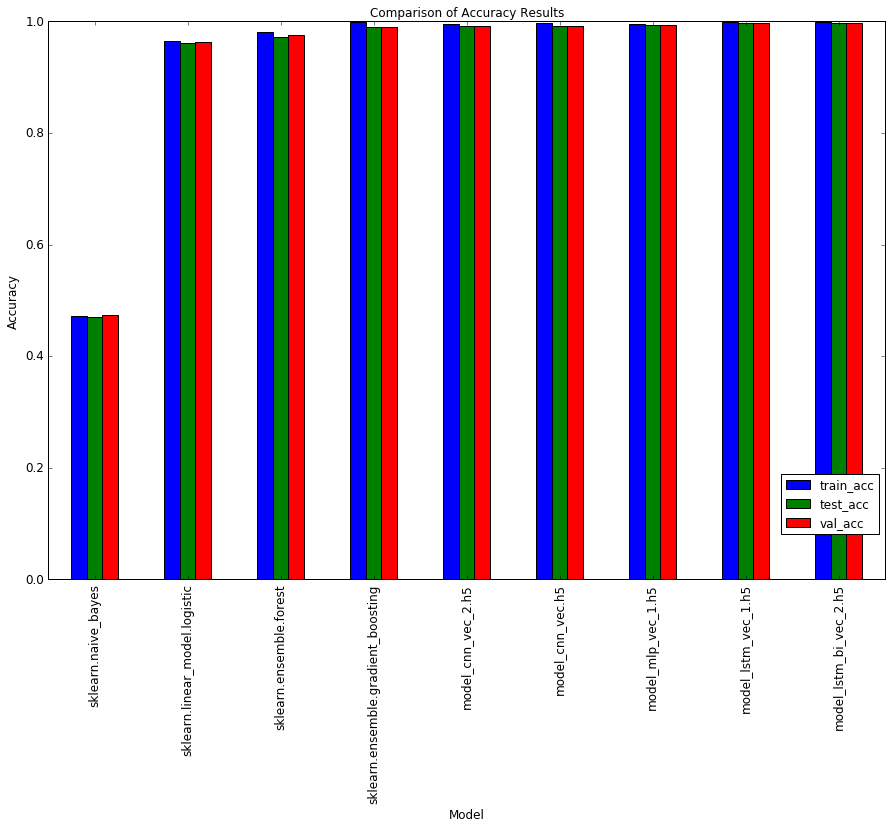

                                   train_acc  test_acc   val_acc
sklearn.naive_bayes                 0.472319  0.469769  0.473226
sklearn.linear_model.logistic       0.964989    0.9613  0.963949
sklearn.ensemble.forest              0.98051  0.971427  0.976481
sklearn.ensemble.gradient_boosting  0.999255  0.989933  0.990885
model_cnn_vec_2.h5                  0.996255    0.9915  0.991455
model_cnn_vec.h5                    0.997287  0.992525  0.992676
model_mlp_vec_1.h5                  0.996064  0.993369  0.993625
model_lstm_vec_1.h5                 0.998862  0.996604  0.996474
model_lstm_bi_vec_2.h5              0.999078  0.996624  0.997016


In [42]:
plot_result = result_table.sort_values(['test_acc', 'val_acc'])


import matplotlib.pyplot as plt
ax = plot_result[['train_acc','test_acc', 'val_acc']].plot(kind='bar', title="Comparison of Accuracy Results", figsize=(15, 10), legend=True ,fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.legend(bbox_to_anchor=(1,0.2))
plt.show()

print plot_result[['train_acc','test_acc', 'val_acc']]



In [43]:
# calculate false negatives for each model and dataset and save it to the plot_results dataframe
plot_result['false_negatives_train']=np.nan
plot_result['false_negatives_test']=np.nan
plot_result['false_negatives_val']=np.nan
for row in plot_result.itertuples():
    confusion = row[4]
    confusion = confusion[2][0]+confusion[1][0]+confusion[0][1]+confusion[2][1]  
    plot_result.set_value(row[0], 'false_negatives_train', confusion)
    #print plot_result[row[0]]['false_negatives_train'] 
    confusion = row[5]
    confusion = confusion[2][0]+confusion[1][0]+confusion[0][1]+confusion[2][1]  
    plot_result.set_value(row[0], 'false_negatives_test', confusion)
    confusion = row[6]
    confusion = confusion[2][0]+confusion[1][0]+confusion[0][1]+confusion[2][1]  
    plot_result.set_value(row[0], 'false_negatives_val', confusion)



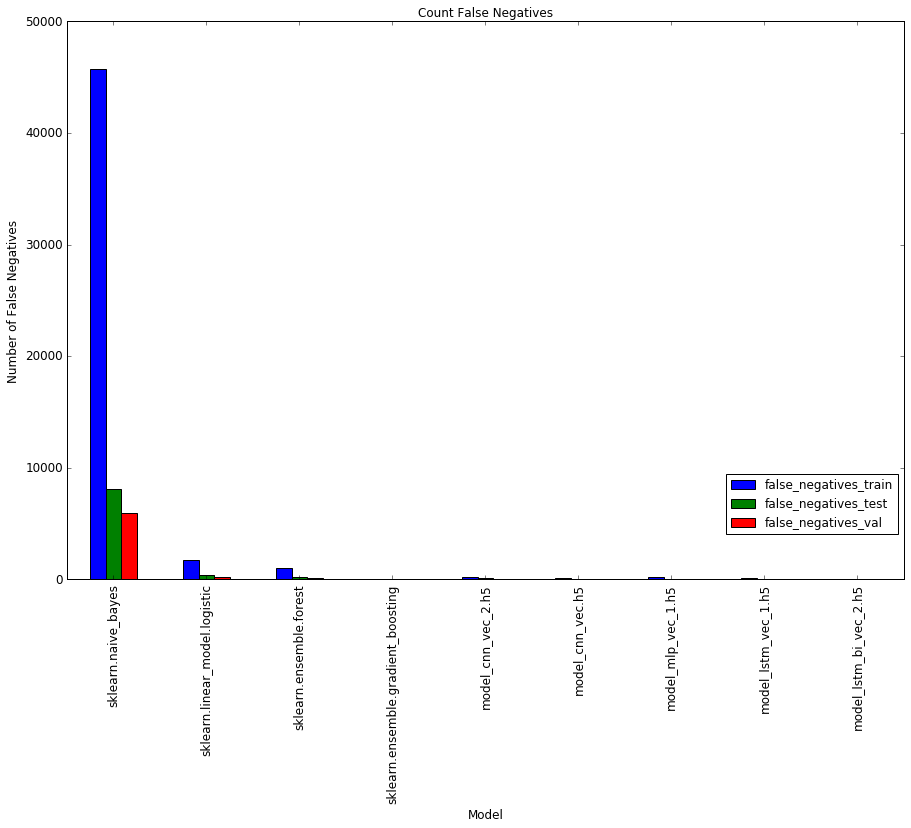

                                    false_negatives_train  \
sklearn.naive_bayes                               45704.0   
sklearn.linear_model.logistic                      1751.0   
sklearn.ensemble.forest                            1009.0   
sklearn.ensemble.gradient_boosting                   40.0   
model_cnn_vec_2.h5                                  228.0   
model_cnn_vec.h5                                    147.0   
model_mlp_vec_1.h5                                  195.0   
model_lstm_vec_1.h5                                  95.0   
model_lstm_bi_vec_2.h5                               56.0   

                                    false_negatives_test  false_negatives_val  
sklearn.naive_bayes                               8134.0               5954.0  
sklearn.linear_model.logistic                      365.0                241.0  
sklearn.ensemble.forest                            250.0                157.0  
sklearn.ensemble.gradient_boosting                  62.0             

In [44]:
ax = plot_result[['false_negatives_train','false_negatives_test', 'false_negatives_val']].plot(kind='bar', title="Count False Negatives", figsize=(15, 10), legend=True ,fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Number of False Negatives", fontsize=12)
ax.legend(bbox_to_anchor=(1,0.2))
plt.show()

print plot_result[['false_negatives_train','false_negatives_test', 'false_negatives_val']]